<a href="https://colab.research.google.com/github/MZiaAfzal71/Reconstruction-of-3D-Objects-and-Parallelisation/blob/main/Reconstruction_PyTorch_vectorized_and_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numba import cuda, njit, prange
import math, random, torch, copy, time
import matplotlib.pyplot as plt
from functools import wraps
from typing import List, Tuple, Optional
import functools
import gc
# import torch_xla
# import torch_xla.core.xla_model as xm

# GPU availability check
USE_GPU = cuda.is_available()
print("✅ GPU Available:", USE_GPU)


# The wraper function "timeit" can be used to measure the time of any function
def timeit(label=None):
    """Decorator to measure and print execution time of functions."""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            start = time.perf_counter()
            result = func(*args, **kwargs)
            end = time.perf_counter()
            name = label or func.__name__
            print(f"[{name}] {end - start:.4f} s")
            return result
        return wrapper
    return decorator


✅ GPU Available: False


In [2]:
def _cross2d_torch(a, b):
    """2D cross product scalar for arrays of 2-vectors: a,b shape (...,2) -> (...,)"""
    return a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0]

# @torch.compile
# @timeit("curves computation at each height")
def curve_goodman_torch(I, seg_pts, r_coef=0.25, s_coef=0.25, m=0.5, n=0.5, device=None):
    """
    Smooth curve through given data points using Goodman’s method (Torch version).

    Parameters
    ----------
    I : (n,2) torch.Tensor
        Input polyline points (closed loop expected).
    seg_pts : int
        Number of interpolation points per segment.

    Returns
    -------
    r : (n*seg_pts,2) torch.Tensor
        Smoothed curve points.
    """
    if device is None:
        device = I.device
    else:
        I = I.to(device)

    dtype = I.dtype
    no_pts = I.shape[0]

    t_vals = torch.linspace(0, 1, seg_pts + 1, dtype=dtype, device=device)[:-1]  # exclude endpoint
    idx = torch.arange(no_pts, dtype=torch.int, device=device)


    # --- Circular indexing (wrap-around)
    im1 = (idx - 1) % no_pts
    ip1 = (idx + 1) % no_pts
    im2 = (idx - 2) % no_pts
    ip2 = (idx + 2) % no_pts


    # --- Initialize tensors
    lineleft = torch.zeros(no_pts, dtype=torch.bool, device=device)
    lineright = torch.zeros_like(lineleft)
    kleft = torch.zeros(no_pts, dtype=dtype, device=device)
    kright = torch.zeros_like(kleft)
    # --- Collinearity checks
    def collinear(p, q, r):
        return torch.abs((q[:,1]-p[:,1])*(r[:,0]-p[:,0]) - (r[:,1]-p[:,1])*(q[:,0]-p[:,0])) < 1e-9

    lineleft |= collinear(I[im1], I[idx], I[ip1])
    lineright |= collinear(I[im1], I[idx], I[ip1])
    lineright |= collinear(I[ip1], I[idx], I[ip2])
    lineleft |= collinear(I[im1], I[idx], I[im2])

    # --- Curvatures (kleft, kright)
    num = 2 * _cross2d_torch(I[idx]-I[im1], I[ip1]-I[idx])
    den = torch.linalg.norm(I[idx]-I[im1], dim=-1) * torch.linalg.norm(I[ip1]-I[idx], dim=-1) * torch.linalg.norm(I[ip1]-I[im1], dim=-1)
    kleft = torch.where(~lineleft, num / torch.clamp(den, min=1e-12), torch.zeros_like(num))
    kright = torch.where(~lineright, num / torch.clamp(den, min=1e-12), torch.zeros_like(num))
    kleft = torch.where(den!=0, kleft, torch.zeros_like(num))
    kright = torch.where(den!=0, kright, torch.zeros_like(num))

    # --- Tangents
    T = torch.zeros_like(I)
    Tu = torch.zeros_like(I)
    a = torch.abs(kleft[ip1]) * torch.linalg.norm(I[ip1]-I[idx], dim=-1)**2
    b = torch.abs(kright[im1]) * torch.linalg.norm(I[idx]-I[im1], dim=-1)**2
    T = a.unsqueeze(-1)*(I[idx]-I[im1]) + b.unsqueeze(-1)*(I[ip1]-I[idx])
    normT = torch.linalg.norm(T, dim=-1, keepdim=True)
    Tu = torch.where(normT > 0, T / normT, torch.zeros_like(T))
    mask = (kleft != 0) | (kright != 0)
    T = T * mask.unsqueeze(-1)
    Tu = Tu * mask.unsqueeze(-1)

    # --- Bezier control points
    A, B, C, D = I.clone(), torch.zeros_like(I), torch.zeros_like(I), I[ip1].clone()
    lengthab = torch.zeros(no_pts, dtype=dtype, device=device)
    lengthcd = torch.zeros_like(lengthab)

    k_prod = kright * kleft[ip1]
    convex_mask = k_prod > 0
    inflect_mask = k_prod < 0

    # Shared distance
    L = torch.linalg.norm(I[ip1]-I[idx], dim=-1)

    # Convex case
    sina = _cross2d_torch(T, I[ip1]-I[idx]) / (torch.linalg.norm(T, dim=-1) * torch.linalg.norm(I[ip1]-I[idx], dim=-1))
    sinb = _cross2d_torch(I[ip1]-I[idx], T[ip1]) / (torch.linalg.norm(T[ip1], dim=-1) * torch.linalg.norm(I[ip1]-I[idx], dim=-1))
    sinab = _cross2d_torch(T, T[ip1]) / (torch.linalg.norm(T, dim=-1) * torch.linalg.norm(T[ip1], dim=-1))

    p = 2*torch.abs(sinb) / (2*m*torch.abs(sinb)+(1-m)*L*torch.abs(kleft[ip1])+2*torch.abs(sinab))
    q = 2*torch.abs(sina) / (2*n*torch.abs(sina)+(1-n)*L*torch.abs(kright)+2*torch.abs(sinab))
    lengthab = torch.where(convex_mask, p*L, lengthab)
    lengthcd = torch.where(convex_mask, q*L, lengthcd)

    B = torch.where(convex_mask.unsqueeze(-1), A + lengthab.unsqueeze(-1)*Tu, B)
    C = torch.where(convex_mask.unsqueeze(-1), D - lengthcd.unsqueeze(-1)*Tu[ip1], C)

    # Inflection case
    lengthab = torch.where(inflect_mask, r_coef*L, lengthab)
    lengthcd = torch.where(inflect_mask, s_coef*L, lengthcd)
    B = torch.where(inflect_mask.unsqueeze(-1), A + lengthab.unsqueeze(-1)*Tu, B)
    C = torch.where(inflect_mask.unsqueeze(-1), D - lengthcd.unsqueeze(-1)*Tu[ip1], C)

    # --- Weights
    alpha = torch.zeros(no_pts, dtype=dtype, device=device)
    beta = torch.zeros_like(alpha)
    denom1 = 2 * _cross2d_torch(B - A, C - B)
    denom2 = 2 * _cross2d_torch(C - B, D - C)

    alpha = torch.where(denom1 != 0, kright * lengthab**3 / denom1, torch.zeros_like(alpha))
    beta = torch.where(denom2 != 0, kleft[ip1] * lengthcd**3 / denom2, torch.zeros_like(beta))

    # --- Build curve points ---
    tj = t_vals.view(1, seg_pts, 1)                    # (1, seg_pts, 1)
    Ai, Bi, Ci, Di = A[:, None, :], B[:, None, :], C[:, None, :], D[:, None, :]  # (no_pts, 1, 2)
    alph = alpha[:, None, None]
    bet = beta[:, None, None]
    mask_nl = (kright != 0).view(-1, 1, 1)             # (no_pts, 1, 1)

    # --- nonlinear branch (vectorized) ---
    num = (Ai * alph * (1 - tj)**3 +
          Bi * tj * (1 - tj)**2 +
          Ci * tj**2 * (1 - tj) +
          Di * bet * tj**3)
    den = alph * (1 - tj)**3 + tj * (1 - tj)**2 + tj**2 * (1 - tj) + bet * tj**3
    r_nl = num / den                                   # (no_pts, seg_pts, 2)

    # --- linear branch (vectorized) ---
    r_lin = (1 - tj) * Ai + tj * Di                    # (no_pts, seg_pts, 2)

    # --- select between them without loop ---
    r_all = torch.where(mask_nl, r_nl, r_lin)          # (no_pts, seg_pts, 2)

    # --- flatten to match your original shape ---
    r = r_all.reshape(no_pts * seg_pts, 2)

    return r

In [3]:
# Calculate total no. of points at each height
def t_no_pts(I, n1, device=None):
    """
    Calculate total number of points (tot_pts) and segment points (seg_pts)
    at each height, compatible with NumPy and PyTorch tensors.

    Parameters
    ----------
    I : list of arrays or tensors
        Each element I[i] contains the point indices at height i.

    Returns
    -------
    tot_pts : torch.Tensor
        LCM of data points at all heights.
    seg_pts : torch.Tensor
        Number of segment points for each height.
    """

    if device is None:
        device = I[0].device

    dtype = torch.int

    # No of points at each height
    P = torch.tensor([x.shape[0] for x in I], dtype=dtype, device=device)

    # LCM of all segment lengths
    lcm_data_pts = functools.reduce(torch.lcm, P)

    lcm_data_pts *= n1
    # Compute segment points for each height
    seg_pts = lcm_data_pts // P

    return lcm_data_pts.item(), seg_pts   # return scalar + tensor

# To obtain R's by Matching Parameters to aviod/minimize twistness in the surface
def match_parameters_torch_seq(r, N, tot_pts, M, device=None):
    if device is None:
        device = r.device

    D = r.shape[-1]
    step = tot_pts // M
    R = r.clone()
    dtype = torch.int

    idx_base = torch.arange(M, dtype=dtype, device=device) * step  # (M,)
    shifts = torch.arange(M, dtype=dtype, device=device)           # (M,)
    idx_shifted = (idx_base[None, :] + shifts[:, None] * step) % tot_pts  # (M,M)

    for i in range(N - 1):
        A = R[i, idx_base, :].unsqueeze(0)       # (1, M, D)
        B = r[i + 1, idx_shifted, :]             # (M, M, D)

        diff = A[:, None, :, :] - B.unsqueeze(0) # (1, M, M, D)
        dists = (diff ** 2).sum(dim=-1).sum(dim=-1).squeeze(0)
        best_shift = torch.argmin(dists)

        perm = (torch.arange(tot_pts, dtype=dtype, device=device) + best_shift * step) % tot_pts
        R[i + 1, :] = r[i + 1, perm]

    R = torch.cat([R, R[:, 0:1, :]], dim=1)
    return R

# Calculates Base and Crown Points
def base_crown_pt(R, N, tot_pts, M, step, device=None):
    """
    Vectorized PyTorch + NumPy compatible version of base_crown_pt().
    Computes base and crown points without Python loops or lists.
    """

    if device is None:
        device = R.device

    dtype = R.dtype

    # Prepare index arrays (for the M//2 pairs)
    half_M = M // 2
    j_idx = torch.arange(half_M, dtype=torch.int, device=device) * step
    k_idx = j_idx + (tot_pts // 2)

    # ----------------- BASE POINTS -----------------
    A = R[0, j_idx]
    B = R[0, k_idx]
    C = R[1, j_idx]
    D = R[1, k_idx]

    alpha = torch.linalg.norm(A - C, dim=1)
    beta  = torch.linalg.norm(A - B, dim=1)
    gamma = torch.linalg.norm(B - D, dim=1)

    # weighted sum for base points
    C_B = (gamma.unsqueeze(1) * A +
            alpha.unsqueeze(1) * B +
            beta.unsqueeze(1) * (A + B)) / (alpha + 2 * beta + gamma).unsqueeze(1)

    # ----------------- CROWN POINTS -----------------
    A = R[N-1, j_idx]
    B = R[N-1, k_idx]
    C = R[N-2, j_idx]
    D = R[N-2, k_idx]

    alpha = torch.linalg.norm(A - C, dim=1)
    beta  = torch.linalg.norm(A - B, dim=1)
    gamma = torch.linalg.norm(B - D, dim=1)

    C_C = (gamma.unsqueeze(1) * A +
            alpha.unsqueeze(1) * B +
            beta.unsqueeze(1) * (A + B)) / (alpha + 2 * beta + gamma).unsqueeze(1)

    # Mean over all pairs
    B_Point = 2.0 / M * torch.sum(C_B, dim=0)
    C_Point = 2.0 / M * torch.sum(C_C, dim=0)

    return B_Point, C_Point

# Calculates Base and Crown Heights
def base_crown_ht(R, N, tot_pts, M, step, Z, Null_Hts, device=None):
    """
    Compute average base (B) and crown (T) heights using circle-fitting.
    Works with NumPy arrays or PyTorch tensors (torch preferred for GPU).

    Parameters
    ----------
    R : (N, tot_pts, 2)
    N : int
    tot_pts : int
    M : int
    step : int
    Z : (N,)
    Null_Hts : (2,)
    """
    if device is None:
      device = R.device


    # Sample index pairs (M equally spaced + opposite point)
    i_idx = torch.arange(M, dtype=torch.int, device=device)
    j_idx = i_idx * step
    k_idx = (i_idx * step + tot_pts // 2) % tot_pts

    # --- Base points ---
    A_b = R[0, j_idx]
    B_b = R[0, k_idx]
    C_b = R[1, j_idx]
    Z0, Z1 = Z[0], Z[1]

    # --- Crown points ---
    A_c = R[N - 1, j_idx]
    B_c = R[N - 1, k_idx]
    C_c = R[N - 2, j_idx]
    ZNm1, ZNm2 = Z[N - 1], Z[N - 2]

    def compute_heights(A, B, C, Z1, Z2, null_ht, reverse=False):
        """Shared block for base/crown height computation."""
        x1, y1 = A[:, 0], A[:, 1]
        x2, y2 = B[:, 0], B[:, 1]
        x3, y3 = C[:, 0], C[:, 1]
        z1 = torch.full_like(x1, Z1)
        z2 = torch.full_like(x2, Z1)
        z3 = torch.full_like(x3, Z2)

        # --- Determinant-based quantities (vectorized) ---
        def det3(a, b, c):
            return (
                a[:, 0] * (b[:, 1] * c[:, 2] - b[:, 2] * c[:, 1])
                - a[:, 1] * (b[:, 0] * c[:, 2] - b[:, 2] * c[:, 0])
                + a[:, 2] * (b[:, 0] * c[:, 1] - b[:, 1] * c[:, 0])
            )

        x4 = -det3(
            torch.stack([y1, z1, torch.ones_like(y1)], dim=1),
            torch.stack([y2, z2, torch.ones_like(y2)], dim=1),
            torch.stack([y3, z3, torch.ones_like(y3)], dim=1)
        )
        y4 = det3(
            torch.stack([x1, z1, torch.ones_like(x1)], dim=1),
            torch.stack([x2, z2, torch.ones_like(x2)], dim=1),
            torch.stack([x3, z3, torch.ones_like(x3)], dim=1)
        )
        z4 = -det3(
            torch.stack([x1, y1, torch.ones_like(x1)], dim=1),
            torch.stack([x2, y2, torch.ones_like(x2)], dim=1),
            torch.stack([x3, y3, torch.ones_like(x3)], dim=1)
        )

        b1 = -(x1**2 + y1**2 + z1**2)
        b2 = -(x2**2 + y2**2 + z2**2)
        b3 = -(x3**2 + y3**2 + z3**2)
        b4 = det3(
            torch.stack([x1, y1, z1], dim=1),
            torch.stack([x2, y2, z2], dim=1),
            torch.stack([x3, y3, z3], dim=1)
        )

        A_mat = torch.stack([
            torch.stack([2*x1, 2*y1, 2*z1, torch.ones_like(x1)], dim=1),
            torch.stack([2*x2, 2*y2, 2*z2, torch.ones_like(x2)], dim=1),
            torch.stack([2*x3, 2*y3, 2*z3, torch.ones_like(x3)], dim=1),
            torch.stack([x4,   y4,   z4,   torch.zeros_like(x4)], dim=1)
        ], dim=1)
        B_vec = torch.stack([b1, b2, b3, b4], dim=1)

        # --- Solve linear system (batched) ---
        X = torch.linalg.solve(A_mat, B_vec.unsqueeze(-1)).squeeze(-1)

        u, v, w, d = X.T
        mdx1, mdy1, mdz1 = (x1+x2)/2, (y1+y2)/2, (z1+z2)/2
        cx2, cy2, cz2 = -u, -v, -w
        a = (cx2 - mdx1) / (cz2 - mdz1)
        b = (cy2 - mdy1) / (cz2 - mdz1)

        p1 = a**2 + b**2 + 1
        p2 = 2*a*(mdx1 - a*mdz1) + 2*b*(mdy1 - b*mdz1) - 2*u*a + 2*v*b + 2*w
        p3 = ((mdx1 - a*mdz1)**2 + (mdy1 - b*mdz1)**2
              + 2*u*(mdx1 - a*mdz1) + 2*v*(mdy1 - b*mdz1) + d)

        disc = p2**2 - 4*p1*p3
        sqrt_disc = torch.sqrt(torch.clamp(disc, min=0))
        root1 = (-p2 + sqrt_disc) / (2*p1)
        root2 = (-p2 - sqrt_disc) / (2*p1)

        if reverse:
            if null_ht > Z1:
                z_out = torch.minimum(null_ht, torch.maximum(root1, root2))
            else:
                z_out = torch.maximum(null_ht, torch.minimum(root1, root2))
        else:
            if null_ht < Z1:
                z_out = torch.maximum(null_ht, torch.minimum(root1, root2))
            else:
                z_out = torch.minimum(null_ht, torch.maximum(root1, root2))
        return z_out

    # --- Compute both heights ---
    zkb = compute_heights(A_b, B_b, C_b, Z0, Z1, Null_Hts[0], reverse=False)
    zkc = compute_heights(A_c, B_c, C_c, ZNm1, ZNm2, Null_Hts[1], reverse=True)

    B = torch.mean(zkb)
    T = torch.mean(zkc)
    return B, T

# Calculates Tangent to the surface
# @timeit("tangents calculations to the surface")
def surf_tangent(R, N, tot_pts, Z, Null_Hts, RB, RC, Bh, T, base_null='y', crown_null='y',  eps=1e-12, device=None):
    """
    Vectorized surf_tangent that works with numpy or torch arrays.
    - R: shape (N, M, 2) where M == tot_pts + 1 (consistent with your loops)
    - Z: shape (N,)
    - RB, RC: shape (2,)
    Returns: (gR, gz, gRB, gRC, fb, fc) of same library type as R
    """
    if device is None:
      device = R.device

    dtype = R.dtype

    # shapes
    M = R.shape[1]            # should be tot_pts + 1
    assert M >= 1
    # Preallocate
    gR = torch.zeros((N, M, 2), dtype=dtype, device=device)
    gz = torch.zeros((N, M), dtype=dtype, device=device)
    gRB = torch.zeros((M, 2), dtype=dtype, device=device)
    gRC = torch.zeros((M, 2), dtype=dtype, device=device)
    fb = torch.zeros((M,), dtype=dtype, device=device)
    fc = torch.zeros((M,), dtype=dtype, device=device)

    if base_null in ('n', 'N'):
        Bh = Null_Hts[0]
    if crown_null in ('n', 'N'):
        T = Null_Hts[1]

    # --------------------------
    # Interior points: i=1..N-2
    # --------------------------
    if N > 2:
        i_idx = torch.arange(1, N - 1, dtype=torch.int, device=device)                # shape (K,)
        K = i_idx.shape[0]

        # A, B, C shapes (K, M, 2)
        A = R[i_idx - 1]    # (K, M, 2)
        B = R[i_idx]        # (K, M, 2)
        C = R[i_idx + 1]    # (K, M, 2)

        # alphaR, betaR: (K, M)
        alphaR = torch.linalg.norm(C - B, axis=2)
        betaR  = torch.linalg.norm(B - A, axis=2)

        # alphaZ, betaZ per i (K,)
        alphaZ = Z[i_idx + 1] - Z[i_idx]     # (K,)
        betaZ  = Z[i_idx] - Z[i_idx - 1]     # (K,)

        # Expand for broadcasting to (K, M)
        alphaZ_b = torch.abs(alphaZ)[:, None]
        betaZ_b  = torch.abs(betaZ)[:, None]

        # denom (K, M) with safe fallback
        denom = alphaR * betaZ_b + betaR * alphaZ_b
        denom_safe = torch.where(denom == 0, eps, denom)

        # numerator (K, M, 2)
        numerator = alphaR[..., None] * (B - A) + betaR[..., None] * (C - B)
        gR_block = numerator / denom_safe[..., None]
        gR[i_idx, :, :] = gR_block

        # gz numerator: alphaR*betaZ + betaR*alphaZ (K, M)
        num_gz = alphaR * betaZ[:, None] + betaR * alphaZ[:, None]
        gz_block = num_gz / denom_safe
        gz[i_idx, :] = gz_block

    # --------------------------
    # Base section i = 0
    # --------------------------
    if N >= 2:
        A = RB               # (2,)
        B0 = R[0]            # (M,2)
        C0 = R[1]            # (M,2)
        alphaR0 = torch.linalg.norm(C0 - B0, axis=1)   # (M,)
        betaR0  = torch.linalg.norm(B0 - A, axis=1)    # (M,)
        alphaZ0 = Z[1] - Z[0]
        betaZ0  = Z[0] - Bh
        denom0 = 2 * alphaR0 * abs(betaZ0) + betaR0 * abs(alphaZ0)
        denom0_safe = torch.where(denom0 == 0, eps, denom0)
        numer0 = (2 * alphaR0)[:, None] * (B0 - A) + betaR0[:, None] * (C0 - B0)
        gR[0, :, :] = numer0 / denom0_safe[:, None]
        gz[0, :] = (2 * alphaR0 * betaZ0 + betaR0 * alphaZ0) / denom0_safe

    # --------------------------
    # Crown section i = N - 1
    # --------------------------
    if N >= 2:
        AN = R[N - 2]    # (M,2)
        BN = R[N - 1]    # (M,2)
        # alphaRN: norm of RC - BN per row
        alphaRN = torch.linalg.norm(RC[None, :] - BN, axis=1)
        betaRN  = torch.linalg.norm(BN - AN, axis=1)
        alphaZN = (T - Z[N - 1]).item()
        betaZN  = (Z[N - 1] - Z[N - 2]).item()
        denomN = alphaRN * abs(betaZN) + 2 * betaRN * abs(alphaZN)
        denomN_safe = torch.where(denomN == 0, eps, denomN)
        numerN = alphaRN[:, None] * (BN - AN) + 2 * betaRN[:, None] * (RC - BN)
        gR[N - 1, :, :] = numerN / denomN_safe[:, None]
        gz[N - 1, :] = (alphaRN * betaZN + 2 * betaRN * alphaZN) / denomN_safe

    # --------------------------
    # gRB vectorized across j
    # --------------------------
    j_idx = torch.arange(M, dtype=torch.int, device=device)
    # deterministic alpha1 (1.0 + j%15)
    alpha1_vec = 1.0 + (j_idx % 15) #.astype(float)
    # beta1 vector computations (vector)
    # For base:
    denom_Z01 = Z[1] - Z[0]
    beta1_vec = (Bh - alpha1_vec * (Z[0] - Bh)) / denom_Z01
    alpha2_vec = -alpha1_vec
    beta2_vec = (Bh - alpha2_vec * (Z[0] - Bh)) / denom_Z01

    B0 = R[0]  # (M,2)
    C0 = R[1]  # (M,2)
    # D1, D2 shapes (M,2)
    D1 = alpha1_vec[:, None] * (B0 - RB) + beta1_vec[:, None] * (C0 - B0)
    D2 = alpha2_vec[:, None] * (B0 - RB) + beta2_vec[:, None] * (C0 - B0)

    # E and F: normalized row-wise
    def _normalize_rows(X):
        norms = torch.linalg.norm(X, axis=1)
        norms_safe = torch.where(norms == 0, eps, norms)
        return X / norms_safe[:, None]

    E = _normalize_rows(B0 - RB)   # (M,2)
    F = _normalize_rows(D1 - D2)   # (M,2)

    # cross2d and dot
    cross_vals = E[:, 0] * F[:, 1] - E[:, 1] * F[:, 0]
    dot_vals = torch.einsum('ij,ij->i', E, F)

    choose_E = torch.abs(cross_vals) < (1e-8)
    choose_F = (~choose_E) & (dot_vals > 0)
    choose_negF = (~choose_E) & (~choose_F)

    gRB[choose_E, :] = E[choose_E, :]
    gRB[choose_F, :] = F[choose_F, :]
    gRB[choose_negF, :] = -F[choose_negF, :]

    # --------------------------
    # gRC vectorized across j
    # --------------------------
    # similar for crown
    alpha1_vec = 1.0 + (j_idx % 15) #.astype(float)
    denom_ZN = (T - Z[N - 1]).item()
    beta1_vec = (T - alpha1_vec * (Z[N - 1] - Z[N - 2])) / (T - Z[N - 1])
    alpha2_vec = -alpha1_vec
    beta2_vec = (T - alpha2_vec * (Z[N - 1] - Z[N - 2])) / (T - Z[N - 1])

    AN = R[N - 2]
    BN = R[N - 1]
    D1 = alpha1_vec[:, None] * (BN - AN) + beta1_vec[:, None] * (RC - BN)
    D2 = alpha2_vec[:, None] * (BN - AN) + beta2_vec[:, None] * (RC - BN)

    E = _normalize_rows(RC - BN)   # (M,2)
    F = _normalize_rows(D1 - D2)   # (M,2)

    cross_vals = E[:, 0] * F[:, 1] - E[:, 1] * F[:, 0]
    dot_vals = torch.einsum('ij,ij->i', E, F)

    choose_E = torch.abs(cross_vals) < (1e-8)
    choose_F = (~choose_E) & (dot_vals > 0)
    choose_negF = (~choose_E) & (~choose_F)

    gRC[choose_E, :] = E[choose_E, :]
    gRC[choose_F, :] = F[choose_F, :]
    gRC[choose_negF, :] = -F[choose_negF, :]

    # --------------------------
    # fb and fc vectorized
    # --------------------------
    B0 = R[0]   # (M,2)
    Cmag = torch.linalg.norm(B0 - RB, axis=1)
    Cmag_safe = torch.where(Cmag == 0, eps, Cmag)
    tmp = gR[0] / Cmag_safe[:, None]
    tmp_norm = torch.linalg.norm(tmp, axis=1)
    fb = torch.sqrt(torch.tensor(2.0)) * Cmag / torch.sqrt(1.0 + abs(Z[0] - Bh) * tmp_norm)

    BN = R[N - 1]
    CmagN = torch.linalg.norm(RC - BN, axis=1)
    CmagN_safe = torch.where(CmagN == 0, eps, CmagN)
    tmp = gR[N - 1] / CmagN_safe[:, None]
    tmp_norm = torch.linalg.norm(tmp, axis=1)
    fc = torch.sqrt(torch.tensor(2.0)) * CmagN / torch.sqrt(1.0 + abs(T - Z[N - 1]) * tmp_norm)

    return gR, gz, gRB, gRC, fb, fc

# Calculate Surface Points
# @timeit("surface points computations")
# @torch.compile(mode="max-autotune")
# def surf_pts(R, N, tot_pts, Z, RB, RC, Bh, T,
#                    gRB, gRC, fb, fc, gR, gz, u, FR, Fz,
#                    base_circular, crown_circular, n, device=None):
#     """
#     Torch version of surf_pts (Option A - direct conversion).

#     Inputs (all torch.Tensor unless otherwise stated):
#       R:        (N, M, 2) where M == tot_pts + 1
#       N:        int (number of contour levels)
#       tot_pts:  int (number of circumferential intervals; M = tot_pts + 1)
#       Z:        (N,)
#       RB, RC:   (2,)
#       Bh, T:    scalars (float)
#       gRB,gRC:  (M,2)
#       fb,fc:    (M,)
#       gR:       (N, M, 2)
#       gz:       (N, M)
#       base_circular, crown_circular: 'y'/'Y' or other string
#       n:        int (number of interpolation steps, so n+1 samples)

#     Returns:
#       FR: (N+1, M, n+1, 2) tensor
#       Fz: (N+1, M, n+1) tensor
#     """
#     if device is None:
#       device = R.device

#     dtype = R.dtype

#     # shapes and precomputations
#     M = R.shape[1]  # equals tot_pts + 1
#     # u = torch.linspace(0.0, 1.0, n + 1, dtype=dtype, device=device)  # (n+1,)

#     L0 = 1.0 - 3.0 * u**2 + 2.0 * u**3      # (n+1,)
#     L1 = 3.0 * u**2 - 2.0 * u**3
#     H0 = u - 2.0 * u**2 + u**3
#     H1 = -u**2 + u**3

#     # allocate outputs
#     # FR = torch.zeros((N + 1, M, n + 1, 2), dtype=dtype, device=device)
#     # Fz = torch.zeros((N + 1, M, n + 1), dtype=dtype, device=device)

#     # ---------- Interior sections ----------
#     if N > 1:
#         K = N - 1
#         A = R[0:K, :, :]      # (K, M, 2)
#         B = R[1:K+1, :, :]    # (K, M, 2)

#         gA = gR[0:K, :, :]    # (K, M, 2)
#         gB = gR[1:K+1, :, :]  # (K, M, 2)

#         gzA = gz[0:K, :]      # (K, M)
#         gzB = gz[1:K+1, :]    # (K, M)

#         # deltaZ per interior segment: shape (K,)
#         deltaZ = torch.abs(Z[1:N] - Z[:N-1]).to(dtype=dtype, device=device)  # (K,)

#         # broadcast-friendly shapes
#         L0_row = L0.view(1, 1, -1)   # (1,1,n+1)
#         L1_row = L1.view(1, 1, -1)
#         H0_row = H0.view(1, 1, -1)
#         H1_row = H1.view(1, 1, -1)
#         deltaZ_col = deltaZ.view(-1, 1, 1)  # (K,1,1)

#         # X coordinate
#         FR[1:N, :, :, 0] = (A[..., 0].unsqueeze(-1) * L0_row +
#                             B[..., 0].unsqueeze(-1) * L1_row +
#                             deltaZ_col * (gA[..., 0].unsqueeze(-1) * H0_row +
#                                           gB[..., 0].unsqueeze(-1) * H1_row))

#         # Y coordinate
#         FR[1:N, :, :, 1] = (A[..., 1].unsqueeze(-1) * L0_row +
#                             B[..., 1].unsqueeze(-1) * L1_row +
#                             deltaZ_col * (gA[..., 1].unsqueeze(-1) * H0_row +
#                                           gB[..., 1].unsqueeze(-1) * H1_row))

#         # Fz interior
#         Z_prev = Z[:N-1].to(dtype=dtype, device=device)   # (K,)
#         Z_next = Z[1:N].to(dtype=dtype, device=device)    # (K,)
#         Fz[1:N, :, :] = (Z_prev.view(-1, 1, 1) * L0_row +
#                          Z_next.view(-1, 1, 1) * L1_row +
#                          deltaZ_col * (gzA.unsqueeze(-1) * H0_row + gzB.unsqueeze(-1) * H1_row))

#     # ---------- Base (index 0) ----------
#     B0 = R[0, :, :]   # (M,2)
#     if M > 1:
#         B1 = R[1, :, :]   # (M,2)
#     else:
#         B1 = B0.clone()

#     # helpers for broadcasting
#     L0_m = L0.view(1, -1)   # (1, n+1)
#     L1_m = L1.view(1, -1)
#     H0_m = H0.view(1, -1)
#     H1_m = H1.view(1, -1)

#     if isinstance(base_circular, str) and base_circular in ('y', 'Y'):
#         # FR[0, j, :, 0]
#         # note: fb is (M,), gRB is (M,2), gR[0] is (M,2)
#         FR[0, :, :, 0] = (L0_m * RB[0]) + (L1_m * B0[:, 0].unsqueeze(-1)) + \
#                (H0_m * (fb.unsqueeze(-1) * gRB[:, 0].unsqueeze(-1))) + \
#                (H1_m * (2.0 * torch.abs(Z[0] - Bh) * gR[0, :, 0].unsqueeze(-1)))

#         FR[0, :, :, 1] = (L0_m * RB[1]) + (L1_m * B0[:, 1].unsqueeze(-1)) + \
#                (H0_m * (fb.unsqueeze(-1) * gRB[:, 1].unsqueeze(-1))) + \
#                (H1_m * (2.0 * torch.abs(Z[0] - Bh) * gR[0, :, 1].unsqueeze(-1)))

#         # FR[0, :, :, 0] = FR0x
#         # FR[0, :, :, 1] = FR0y

#         Fz[0, :, :] = ((1.0 - u**2).view(1, -1) * Bh) + (u**2).view(1, -1) * Z[0]
#     else:
#         FR[0, :, :, 0] = (L0_m * RB[0]) + (L1_m * B0[:, 0].unsqueeze(-1)) + \
#                (H1_m * (2.0 * torch.abs(Z[0] - Bh) * gR[0, :, 0].unsqueeze(-1)))

#         FR[0, :, :, 0] = (L0_m * RB[1]) + (L1_m * B0[:, 1].unsqueeze(-1)) + \
#                (H1_m * (2.0 * torch.abs(Z[0] - Bh) * gR[0, :, 1].unsqueeze(-1)))

#         # FR[0, :, :, 0] = FR0x
#         # FR[0, :, :, 1] = FR0y

#         Fz[0, :, :] = ((Bh * L0).view(1, -1) + (Z[0] * L1).view(1, -1) +
#                        ((Z[0] - Bh) * H0).view(1, -1) +
#                        (torch.abs(Z[0] - Bh) * gz[0, :, None] * H1_m))

#     # ---------- Crown (index N) ----------
#     BN = R[N - 1, :, :]  # (M,2)
#     if isinstance(crown_circular, str) and crown_circular in ('y', 'Y'):
#         FR[N, :, :, 0] = (L0_m * BN[:, 0].unsqueeze(-1)) + (L1_m * RC[0]) + \
#                (H1_m * (fc.unsqueeze(-1) * gRC[:, 0].unsqueeze(-1))) + \
#                (H0_m * (2.0 * torch.abs(T - Z[N - 1]) * gR[N - 1, :, 0].unsqueeze(-1)))

#         FR[N, :, :, 0] = (L0_m * BN[:, 1].unsqueeze(-1)) + (L1_m * RC[1]) + \
#                (H1_m * (fc.unsqueeze(-1) * gRC[:, 1].unsqueeze(-1))) + \
#                (H0_m * (2.0 * torch.abs(T - Z[N - 1]) * gR[N - 1, :, 1].unsqueeze(-1)))

#         # FR[N, :, :, 0] = FRNx
#         # FR[N, :, :, 1] = FRNy

#         Fz[N, :, :] = (((1.0 - u)**2).view(1, -1) * Z[N - 1]) + ((u * (2.0 - u)).view(1, -1) * T)
#     else:
#         FR[N, :, :, 0] = (L0_m * BN[:, 0].unsqueeze(-1)) + (L1_m * RC[0]) + \
#                (H0_m * (2.0 * torch.abs(T - Z[N - 1]) * gR[N - 1, :, 0].unsqueeze(-1)))

#         FR[N, :, :, 1] = (L0_m * BN[:, 1].unsqueeze(-1)) + (L1_m * RC[1]) + \
#                (H0_m * (2.0 * torch.abs(T - Z[N - 1]) * gR[N - 1, :, 1].unsqueeze(-1)))

#         # FR[N, :, :, 0] = FRNx
#         # FR[N, :, :, 1] = FRNy

#         Fz[N, :, :] = ((Z[N - 1] * L0).view(1, -1) + (T * L1).view(1, -1) +
#                        (torch.abs(T - Z[N - 1]) * gz[N - 1, :, None] * H0_m) +
#                        (((T - Z[N - 1]) * H1).view(1, -1)))

#     # return FR, Fz

def surf_pts_inplace_vectorized(R, N, tot_pts, Z, RB, RC, Bh, T,
                                gRB, gRC, fb, fc, gR, gz, FR, Fz,
                                base_circular, crown_circular, n, device=None):
    """
    Fully-vectorized, in-place surf_pts that avoids allocating new large tensors
    by reusing preallocated temporary buffers.

    Preconditions (must be satisfied by caller):
      - FR shape == (N+1, M, n+1, 2) and already zeroed
      - Fz shape == (N+1, M, n+1) and already zeroed
      - All inputs on same device and dtype, requires_grad=False
      - device, dtype inferred from R if not provided

    This function writes into FR and Fz in-place and returns None.
    """

    if device is None:
        device = R.device
    dtype = R.dtype

    M = R.shape[1]  # tot_pts + 1

    # precompute 1D blending polynomials (n+1,)
    u = torch.linspace(0.0, 1.0, n2 + 1, dtype=dtype, device=device)  # (n+1,)
    # keep them on correct dtype/device
    L0 = (1.0 - 3.0 * u**2 + 2.0 * u**3).to(dtype=dtype, device=device)   # (n+1,)
    L1 = (3.0 * u**2 - 2.0 * u**3).to(dtype=dtype, device=device)
    H0 = (u - 2.0 * u**2 + u**3).to(dtype=dtype, device=device)
    H1 = (-u**2 + u**3).to(dtype=dtype, device=device)

    # ---- Prepare broadcasting views used in out= ops ----
    # shapes used by vectorized ops:
    # L0_row, etc. have shape (1, 1, n+1) to broadcast with (K,M,n+1)
    L0_row = L0.view(1, 1, -1)
    L1_row = L1.view(1, 1, -1)
    H0_row = H0.view(1, 1, -1)
    H1_row = H1.view(1, 1, -1)

    # ---- Interior block temp buffers ----
    # For N>1, K = N-1 interior segments to fill FR[1:N,...]
    if N > 1:
        K = N - 1

        # Preallocate a reusable large temp buffer for interior computations:
        # tmp_KMn will be reused for X and Y and Fz partial computations.
        # Shape: (K, M, n+1)
        tmp_KMn = torch.empty((K, M, n + 1), dtype=dtype, device=device)

        # Views / slices for convenience (no new allocation):
        A = R[0:K, :, :]       # (K, M, 2)
        B = R[1:K+1, :, :]     # (K, M, 2)
        gA = gR[0:K, :, :]     # (K, M, 2)
        gB = gR[1:K+1, :, :]   # (K, M, 2)
        gzA = gz[0:K, :]       # (K, M)
        gzB = gz[1:K+1, :]     # (K, M)

        # deltaZ_col shape (K,1,1) used in broadcasted multiplications
        deltaZ = torch.abs(Z[1:N] - Z[:N - 1]).to(dtype=dtype, device=device)  # (K,)
        deltaZ_col = deltaZ.view(K, 1, 1)

        # ---- Fill FR[1:N, :, :, 0] (X) in-place without temporaries ----
        FRx = FR[1:N, :, :, 0]   # view shape (K, M, n+1)
        # Step 1: FRx = A[...,0] * L0_row  (use out=FRx)
        torch.mul(A[..., 0].unsqueeze(-1), L0_row, out=FRx)   # writes into FRx directly

        # Step 2: FRx += B[...,0] * L1_row  (use addcmul pattern -> FRx += B * L1)
        # but addcmul_ expects two tensors multiplied; we can use addcmul_ with second operand L1_row
        # FRx += (B[...,0].unsqueeze(-1) * L1_row)
        FRx.addcmul_(B[..., 0].unsqueeze(-1), L1_row, value=1.0)

        # Step 3: FRx += deltaZ_col * (gA[...,0]*H0_row + gB[...,0]*H1_row)
        # compute tmp_KMn = gA[...,0].unsqueeze(-1) * H0_row  (out to tmp)
        torch.mul(gA[..., 0].unsqueeze(-1), H0_row, out=tmp_KMn)
        # tmp_KMn += gB[...,0].unsqueeze(-1) * H1_row
        tmp_KMn.addcmul_(gB[..., 0].unsqueeze(-1), H1_row, value=1.0)
        # Now scale by deltaZ_col and add to FRx in-place
        FRx.add_(tmp_KMn * deltaZ_col)   # tmp_KMn * deltaZ_col will broadcast deltaZ_col (small) — produces a *view-like* expression but this multiplication will allocate a temporary of shape (K,M,n+1) only if PyTorch cannot fuse; however it's a cheap elementwise op using tmp_KMn (already allocated) times small deltaZ_col (broadcast) and then added into FRx in one operation. If you want strictly no alloc even for this, use a loop over K slices to multiply by scalar deltaZ[k] per slice (see below).

        # ---- Fill FR[1:N, :, :, 1] (Y) ----
        FRy = FR[1:N, :, :, 1]
        torch.mul(A[..., 1].unsqueeze(-1), L0_row, out=FRy)
        FRy.addcmul_(B[..., 1].unsqueeze(-1), L1_row, value=1.0)
        # reuse tmp_KMn for Y temp
        torch.mul(gA[..., 1].unsqueeze(-1), H0_row, out=tmp_KMn)
        tmp_KMn.addcmul_(gB[..., 1].unsqueeze(-1), H1_row, value=1.0)
        FRy.add_(tmp_KMn * deltaZ_col)

        # ---- Fill Fz[1:N, :, :] (interior) ----
        Fz_interior = Fz[1:N, :, :]   # shape (K, M, n+1)
        # Fz = Z_prev * L0_row + Z_next * L1_row + deltaZ_col * (gzA.unsqueeze(-1)*H0_row + gzB.unsqueeze(-1)*H1_row)
        # compute tmp_KMn = gzA.unsqueeze(-1) * H0_row
        torch.mul(gzA.unsqueeze(-1), H0_row, out=tmp_KMn)
        tmp_KMn.addcmul_(gzB.unsqueeze(-1), H1_row, value=1.0)
        # now Fz_interior = Z_prev * L0_row (out) then add Z_next*L1_row and deltaZ_col*tmp_KMn
        Z_prev = Z[:N - 1].to(dtype=dtype, device=device).view(K, 1, 1)   # (K,1,1)
        Z_next = Z[1:N].to(dtype=dtype, device=device).view(K, 1, 1)
        # write Z_prev * L0_row into Fz_interior
        Fz_interior.addcmul_(Z_prev, L0_row, value=1.0)
        # add Z_next * L1_row
        Fz_interior.addcmul_(Z_next, L1_row, value=1.0)
        # add deltaZ_col * tmp_KMn
        Fz_interior.add_(tmp_KMn * deltaZ_col)

    else:
        # No interior segments; nothing to do here
        tmp_KMn = None
        deltaZ_col = None

    # ---- Base (index 0) vectorized, in-place ----
    # FR[0, :, :, 0] and FR[0, :, :, 1] are (M, n+1)
    FR0x = FR[0, :, :, 0]   # (M, n+1)
    FR0y = FR[0, :, :, 1]
    # Broadcast helpers
    L0_m = L0.view(1, -1)   # (1, n+1)
    L1_m = L1.view(1, -1)
    H0_m = H0.view(1, -1)
    H1_m = H1.view(1, -1)

    B0 = R[0, :, :]   # (M,2)

    if isinstance(base_circular, str) and base_circular in ('y', 'Y'):
        # FR0x = L0_m * RB[0] + L1_m * B0[:,0].unsqueeze(-1) + H0_m*(fb.unsqueeze(-1)*gRB[:,0].unsqueeze(-1)) + H1_m*(2*abs(Z0-Bh)*gR[0,:,0].unsqueeze(-1))
        # stepwise, in-place
        FR0x.fill_(0.0)
        # add L0*RB[0] (scalar broadcast)
        FR0x.add_(L0_m * RB[0])
        # add L1 * B0[:,0]
        FR0x.add_(B0[:, 0].unsqueeze(-1) * L1_m)
        # add H0 * (fb * gRB[:,0])
        FR0x.add_((fb.unsqueeze(-1) * gRB[:, 0].unsqueeze(-1)) * H0_m)
        # add H1 * (2 * |Z0-Bh| * gR[0,:,0])
        FR0x.add_((2.0 * torch.abs(Z[0] - Bh) * gR[0, :, 0].unsqueeze(-1)) * H1_m)

        FR0y.fill_(0.0)
        FR0y.add_(L0_m * RB[1])
        FR0y.add_(B0[:, 1].unsqueeze(-1) * L1_m)
        FR0y.add_((fb.unsqueeze(-1) * gRB[:, 1].unsqueeze(-1)) * H0_m)
        FR0y.add_((2.0 * torch.abs(Z[0] - Bh) * gR[0, :, 1].unsqueeze(-1)) * H1_m)

        # Fz[0] = (1-u^2)*Bh + u^2*Z0
        Fz0 = Fz[0, :, :]   # (M, n+1)
        Fz0.fill_(0.0)
        Fz0.add_((1.0 - u**2).view(1, -1) * Bh)
        Fz0.add_((u**2).view(1, -1) * Z[0])
    else:
        # Non-circular base
        FR0x.fill_(0.0)
        FR0x.add_(L0_m * RB[0])
        FR0x.add_(B0[:, 0].unsqueeze(-1) * L1_m)
        FR0x.add_((2.0 * torch.abs(Z[0] - Bh) * gR[0, :, 0].unsqueeze(-1)) * H1_m)

        FR0y.fill_(0.0)
        FR0y.add_(L0_m * RB[1])
        FR0y.add_(B0[:, 1].unsqueeze(-1) * L1_m)
        FR0y.add_((2.0 * torch.abs(Z[0] - Bh) * gR[0, :, 1].unsqueeze(-1)) * H1_m)

        Fz0 = Fz[0, :, :]
        Fz0.fill_(0.0)
        Fz0.add_(Bh * L0_m)
        Fz0.add_(Z[0] * L1_m)
        Fz0.add_(((Z[0] - Bh) * H0).view(1, -1))
        Fz0.add_(torch.abs(Z[0] - Bh) * (gz[0, :].unsqueeze(-1) * H1_m))

    # ---- Crown (index N) vectorized, in-place ----
    FRNx = FR[N, :, :, 0]
    FRNy = FR[N, :, :, 1]
    BN = R[N - 1, :, :]  # (M,2)

    if isinstance(crown_circular, str) and crown_circular in ('y', 'Y'):
        FRNx.fill_(0.0)
        FRNx.add_(BN[:, 0].unsqueeze(-1) * L0_m)
        FRNx.add_(L1_m * RC[0])
        FRNx.add_((fc.unsqueeze(-1) * gRC[:, 0].unsqueeze(-1)) * H1_m)
        FRNx.add_((2.0 * torch.abs(T - Z[N - 1]) * gR[N - 1, :, 0].unsqueeze(-1)) * H0_m)

        FRNy.fill_(0.0)
        FRNy.add_(BN[:, 1].unsqueeze(-1) * L0_m)
        FRNy.add_(L1_m * RC[1])
        FRNy.add_((fc.unsqueeze(-1) * gRC[:, 1].unsqueeze(-1)) * H1_m)
        FRNy.add_((2.0 * torch.abs(T - Z[N - 1]) * gR[N - 1, :, 1].unsqueeze(-1)) * H0_m)

        FzN = Fz[N, :, :]
        FzN.fill_(0.0)
        FzN.add_(((1.0 - u)**2).view(1, -1) * Z[N - 1])
        FzN.add_((u * (2.0 - u)).view(1, -1) * T)
    else:
        FRNx.fill_(0.0)
        FRNx.add_(BN[:, 0].unsqueeze(-1) * L0_m)
        FRNx.add_(L1_m * RC[0])
        FRNx.add_((2.0 * torch.abs(T - Z[N - 1]) * gR[N - 1, :, 0].unsqueeze(-1)) * H0_m)

        FRNy.fill_(0.0)
        FRNy.add_(BN[:, 1].unsqueeze(-1) * L0_m)
        FRNy.add_(L1_m * RC[1])
        FRNy.add_((2.0 * torch.abs(T - Z[N - 1]) * gR[N - 1, :, 1].unsqueeze(-1)) * H0_m)

        FzN = Fz[N, :, :]
        FzN.fill_(0.0)
        FzN.add_((Z[N - 1] * L0_m))
        FzN.add_(T * L1_m)
        FzN.add_(torch.abs(T - Z[N - 1]) * (gz[N - 1, :].unsqueeze(-1) * H0_m))
        FzN.add_(((T - Z[N - 1]) * H1).view(1, -1))

    # Done — function modifies FR and Fz in-place; no return necessary
    return None



def surf_pts_inplace(R, N, tot_pts, Z, RB, RC, Bh, T,
                     gRB, gRC, fb, fc, gR, gz, FR, Fz,
                     base_circular, crown_circular, n, device=None):
    """
    Memory-safe, in-place surf_pts: write into preallocated FR, Fz without creating
    large broadcasted temporaries. Loops over the interpolation dimension `u`.
    Preconditions:
      - All tensors (R, Z, RB, RC, gRB, gRC, gR, gz, u, FR, Fz) are on the same device/dtype.
      - FR shape == (N+1, M, n+1, 2)
      - Fz shape == (N+1, M, n+1)
      - requires_grad == False for all tensors
    """
    if device is None:
        device = R.device
    dtype = R.dtype

    M = R.shape[1]          # tot_pts + 1

    u = torch.linspace(0.0, 1.0, n2 + 1, dtype=dtype, device=device)  # (n+1,)
    # Precompute 1D blending polynomials (u is (n+1,))
    L0 = (1.0 - 3.0 * u**2 + 2.0 * u**3).to(dtype=dtype, device=device)   # (n+1,)
    L1 = (3.0 * u**2 - 2.0 * u**3).to(dtype=dtype, device=device)
    H0 = (u - 2.0 * u**2 + u**3).to(dtype=dtype, device=device)
    H1 = (-u**2 + u**3).to(dtype=dtype, device=device)

    # interior ranges
    if N > 1:
        K = N - 1
        A = R[0:K, :, :]        # (K, M, 2)
        B = R[1:K+1, :, :]      # (K, M, 2)
        gA = gR[0:K, :, :]      # (K, M, 2)
        gB = gR[1:K+1, :, :]    # (K, M, 2)
        gzA = gz[0:K, :]        # (K, M)
        gzB = gz[1:K+1, :]      # (K, M)
        deltaZ = torch.abs(Z[1:N] - Z[:N-1]).to(dtype=dtype, device=device)  # (K,)

        # reshape helpers for small-slice usage
        deltaZ_col = deltaZ.view(K, 1)   # (K,1) used in elementwise multiplication with (K,M) slices

    # base / crown helpers
    B0 = R[0, :, :]       # (M,2)
    BN = R[N-1, :, :]     # (M,2)

    # loop over interpolation samples (n+1). This prevents large (K,M,n) temporaries.
    for t_idx in range(n + 1):
        l0 = L0[t_idx]   # scalar tensor
        l1 = L1[t_idx]
        h0 = H0[t_idx]
        h1 = H1[t_idx]

        # ---------------- Interior (indices 1..N-1 correspond to segments 0..K-1) ----------------
        if N > 1:
            # compute X coordinate slice for all segments at this t
            # FR[1:N, :, t_idx, 0] has shape (K, M)
            FRx_slice = FR[1:N, :, t_idx, 0]   # view -> shape (K,M)
            # FRx_slice = A[...,0]*l0  (in-place)
            torch.mul(A[..., 0], l0, out=FRx_slice)             # writes (K,M)
            # add B * l1
            FRx_slice.add_(B[..., 0] * l1)                       # in-place add small (K,M) temp
            # add deltaZ * (gA*h0 + gB*h1)
            # compute gA*h0 into tmp (reuse a small temporary of shape (K,M) via elementwise ops)
            tmp = gA[..., 0] * h0                                 # (K,M) small temp
            tmp = tmp + (gB[..., 0] * h1)                         # tmp now (K,M)
            FRx_slice.add_(deltaZ_col * tmp)                      # in-place final add

            # Y coordinate slice
            FRy_slice = FR[1:N, :, t_idx, 1]
            torch.mul(A[..., 1], l0, out=FRy_slice)
            FRy_slice.add_(B[..., 1] * l1)
            tmp2 = gA[..., 1] * h0
            tmp2 = tmp2 + (gB[..., 1] * h1)
            FRy_slice.add_(deltaZ_col * tmp2)

            # Fz interior: Fz[1:N, :, t_idx] (K,M)
            Fz_slice = Fz[1:N, :, t_idx]
            # Z_prev * l0 + Z_next * l1 + deltaZ * (gzA*h0 + gzB*h1)
            Z_prev = Z[:N-1].to(dtype=dtype, device=device).view(K, 1)   # (K,1)
            Z_next = Z[1:N].to(dtype=dtype, device=device).view(K, 1)
            Fz_slice.add_(Z_prev * l0)                          # Fz_slice = Z_prev * l0
            Fz_slice.add_(Z_next * l1)                                   # add Z_next * l1
            tmpz = (gzA * h0) + (gzB * h1)                               # (K,M) small temp
            Fz_slice.add_(deltaZ_col * tmpz)                             # add deltaZ * tmpz

        # ---------------- Base (index 0) ----------------
        # FR[0, :, t_idx, :]
        FR0x = FR[0, :, t_idx, 0]   # (M,)
        FR0y = FR[0, :, t_idx, 1]
        if isinstance(base_circular, str) and base_circular in ('y', 'Y'):
            # FR0x = L0*RB[0] + L1*B0[:,0] + H0*(fb * gRB[:,0]) + H1*(2*abs(Z0-Bh)*gR[0,:,0])
            # start with L0*RB[0]  (scalar * 1 -> filled across M)
            FR0x.fill_(0.0)
            FR0x.add_(l0 * RB[0])                             # small scalar broadcast
            FR0x.add_(B0[:, 0] * l1)                          # (M,)
            FR0x.add_( (fb * gRB[:, 0]) * h0 )                # (M,)
            FR0x.add_( (2.0 * torch.abs(Z[0] - Bh) * gR[0, :, 0]) * h1 )

            FR0y.fill_(0.0)
            FR0y.add_(l0 * RB[1])
            FR0y.add_(B0[:, 1] * l1)
            FR0y.add_( (fb * gRB[:, 1]) * h0 )
            FR0y.add_( (2.0 * torch.abs(Z[0] - Bh) * gR[0, :, 1]) * h1 )

            # Fz[0, :, t_idx] = (1-u^2)*Bh + u^2 * Z0
            Fz[0, :, t_idx].fill_(0.0)
            Fz[0, :, t_idx].add_((1.0 - u[t_idx]**2) * Bh)
            Fz[0, :, t_idx].add_( (u[t_idx]**2) * Z[0] )

        else:
            # Non-circular base: simpler form
            FR0x.fill_(0.0)
            FR0x.add_(l0 * RB[0])
            FR0x.add_(B0[:, 0] * l1)
            FR0x.add_( (2.0 * torch.abs(Z[0] - Bh) * gR[0, :, 0]) * h1 )

            FR0y.fill_(0.0)
            FR0y.add_(l0 * RB[1])          # note: your earlier code had a typo rewriting index 0 twice; fixed here
            FR0y.add_(B0[:, 1] * l1)
            FR0y.add_( (2.0 * torch.abs(Z[0] - Bh) * gR[0, :, 1]) * h1 )

            # Fz[0,...]
            Fz0_slice = Fz[0, :, t_idx]
            Fz0_slice.fill_(0.0)
            Fz0_slice.add_(Bh * l0)
            Fz0_slice.add_(Z[0] * l1)
            Fz0_slice.add_((Z[0] - Bh) * h0)
            Fz0_slice.add_( torch.abs(Z[0] - Bh) * (gz[0, :] * h1) )

        # ---------------- Crown (index N) ----------------
        FRNx = FR[N, :, t_idx, 0]
        FRNy = FR[N, :, t_idx, 1]
        if isinstance(crown_circular, str) and crown_circular in ('y', 'Y'):
            FRNx.fill_(0.0)
            FRNx.add_(BN[:, 0] * l0)
            FRNx.add_(l1 * RC[0])
            FRNx.add_( (fc * gRC[:, 0]) * h1 )
            FRNx.add_( (2.0 * torch.abs(T - Z[N - 1]) * gR[N - 1, :, 0]) * h0 )

            FRNy.fill_(0.0)
            FRNy.add_(BN[:, 1] * l0)
            FRNy.add_(l1 * RC[1])
            FRNy.add_( (fc * gRC[:, 1]) * h1 )
            FRNy.add_( (2.0 * torch.abs(T - Z[N - 1]) * gR[N - 1, :, 1]) * h0 )

            Fz[N, :, t_idx].fill_(0.0)
            Fz[N, :, t_idx].add_((1.0 - u[t_idx])**2 * Z[N - 1])
            Fz[N, :, t_idx].add_( (u[t_idx] * (2.0 - u[t_idx])) * T )
        else:
            FRNx.fill_(0.0)
            FRNx.add_(BN[:, 0] * l0)
            FRNx.add_(l1 * RC[0])
            FRNx.add_( (2.0 * torch.abs(T - Z[N - 1]) * gR[N - 1, :, 0]) * h0 )

            FRNy.fill_(0.0)
            FRNy.add_(BN[:, 1] * l0)
            FRNy.add_(l1 * RC[1])
            FRNy.add_( (2.0 * torch.abs(T - Z[N - 1]) * gR[N - 1, :, 1]) * h0 )

            FzN_slice = Fz[N, :, t_idx]
            FzN_slice.fill_(0.0)
            FzN_slice.add_(Z[N - 1] * l0)
            FzN_slice.add_(T * l1)
            FzN_slice.add_( torch.abs(T - Z[N - 1]) * (gz[N - 1, :] * h0) )
            FzN_slice.add_((T - Z[N - 1]) * h1)

    # finished filling FR and Fz in-place
    return None




In [4]:
def data_3d_shape(ds = 'banana', dtype=torch.float64, device='cpu'):
    if ds.lower() == 'banana':
        ################################################################################
        ####################          BANANA DATA           ###########################
        ################################################################################
        P = [[[0, 0, -3], [0.5, 0.75, -3], [0, 1.5, -3], [-0.5, 0.75, -3]],
             [[0, 1, -2], [0.6, 2, -2], [0, 3, -2], [-0.6, 2, -2]],
             [[0, 1.9, -1], [0.6, 2.9, -1], [0, 3.9, -1], [-0.6, 2.9, -1]],
             [[0, 2.6, 0], [0.6, 3.4, 0], [0, 4.2, 0], [-0.6, 3.4, 0]],
             [[0, 3, 1], [0.5, 3.65, 1], [0, 4.3, 1], [-0.5, 3.65, 1]],
             [[0, 3.2, 2], [0.15, 3.35, 2], [0, 3.5, 2], [-0.15, 3.35, 2]],
             [[0, 3, 2.3], [0.2, 3.3, 2.3], [0, 3.6, 2.3], [-0.2, 3.3, 2.3]]]
        Null_Hts = torch.tensor([-3.5, 2.8], dtype=dtype, device=device)
    elif ds.lower() == 'apple':
        ################################################################################
        ####################          APPLE DATA           ###########################
        ################################################################################
        P = [[[0.2, 0, 2.3], [0, 0.2, 2.3], [-0.2, 0, 2.3], [0, -0.2, 2.3]],
            [[0.7, 0, 0.7], [0, 0.7, 0.7], [-0.7, 0, 0.7], [0, -0.7, 0.7]],
            [[3, 0, 0], [0, 3, 0], [-3, 0, 0], [0, -3, 0]],
            [[6, 0, 2], [0, 6, 2], [-6, 0, 2], [0, -6, 2]],
            [[7.5, 0, 7], [0, 7.5, 7], [-7.5, 0, 7], [0, -7.5, 7]],
            [[7, 0, 9], [0, 7, 9], [-7, 0, 9], [0, -7, 9]],
            [[4, 0, 11], [0, 4, 11], [-4, 0, 11], [0, -4, 11]],
            [[1.3, 0, 10.5], [0, 1.3, 10.5], [-1.3, 0, 10.5], [0, -1.3, 10.5]],
            [[0.7, 0, 9.5], [0, 0.7, 9.5], [-0.7, 0, 9.5], [0, -0.7, 9.5]]]
        Null_Hts = torch.tensor([3.5, 7.3], dtype=dtype, device=device)
    else:
        ################################################################################
        ####################          VASE DATA           ###########################
        ################################################################################
        P = [
             [[3, 0, 0.75], [0, 3, 0.75], [-3, 0, 0.75], [0, -3, 0.75]],
             [[3.75, 0, 0], [0, 3.75, 0], [-3.75, 0, 0], [0, -3.75, 0]],
             [[3.5, 0, 0.75], [0, 3.5, 0.75], [-3.5, 0, 0.75], [0, -3.5, 0.75]],
             [[3.25, 0, 1.5], [0, 3.25, 1.5], [-3.25, 0, 1.5], [0, -3.25, 1.5]],
             [[6., 0, 5], [0, 6, 5.], [-6, 0, 5.], [0, -6, 5.]],
             [[3.5, 0, 8], [0, 3.5, 8], [-3.5, 0, 8], [0, -3.5, 8]],
             [[1.75, 0, 15], [0, 1.75, 15], [-1.75, 0, 15], [0, -1.75, 15]],
             [[3, 0, 21.5], [0, 3, 21.5], [-3, 0, 21.5], [0, -3, 21.5]],
             [[4, 0, 21.], [0, 4., 21], [-4., 0, 21], [0, -4., 21]]
             ]
        Null_Hts = torch.tensor([1.7, 20.0], dtype=dtype, device=device)


    I = []
    Z = []
    for row in P:
        # only (x,y)
        pts = torch.tensor([p[:2] for p in row], dtype=dtype, device=device)
        I.append(pts)
        # Take the z-value (last element of the last point in row)
        Z.append(row[-1][-1])

    Z = torch.tensor(Z, dtype=dtype, device=device)  # shape (n,)
    return I, Z, Null_Hts

In [5]:
python_stats_banana = pd.DataFrame(columns=['Start time', 'Curves ST', 'Curves ET', 'Tangents ST', 'Tangents ET', 'Surface ST', 'Surface ET/End Time', 'n2', 'dtype'])
python_stats_apple = pd.DataFrame(columns=['Start time', 'Curves ST', 'Curves ET', 'Tangents ST', 'Tangents ET', 'Surface ST', 'Surface ET/End Time', 'n2', 'dtype'])
python_stats_vase = pd.DataFrame(columns=['Start time', 'Curves ST', 'Curves ET', 'Tangents ST', 'Tangents ET', 'Surface ST', 'Surface ET/End Time', 'n2', 'dtype'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch_xla.device()
dtypes = [torch.float64, torch.float32]

N1 = [300, 625, 1250] # The number of points generated horizontally on each countour = 60 * n1
N2 = [1200, 2500, 5000] # The number of points generated in vertical directions

for n1, n2 in zip(N1, N2):
  for dt in dtypes:
    for ds in ['banana', 'apple', 'vase']:
      for i in range(10):
        t0 = time.perf_counter()
        I, Z, Null_Hts = data_3d_shape(ds, dtype=dt, device=device)

        tot_pts, seg_pts = t_no_pts(I, n1)

        N = len(seg_pts)
        M = 4
        step = tot_pts // M

        t1 = time.perf_counter()
        r = []
        for k in range(len(I)):
            r.append(curve_goodman_torch(I[k], seg_pts[k]))

        r = torch.stack(r).to(device)
        t2 = time.perf_counter()
        R = match_parameters_torch_seq(r, N, tot_pts, M)
        B_Point, C_Point = base_crown_pt(R, N, tot_pts, M, step)

        if ds == 'apple':
          B = Null_Hts[0]
          T = Null_Hts[1]
          bt = ct = 'n'
        else:
          B, T = base_crown_ht(R, N, tot_pts, M, step, Z, Null_Hts)
          bt = ct = 'y'

        t3 = time.perf_counter()
        gR, gz, gRB, gRC, fb, fc = surf_tangent(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
        t4 = time.perf_counter()
        FR = torch.zeros((N + 1, tot_pts + 1, n2 + 1, 2), dtype=dt, device=device)
        Fz = torch.zeros((N + 1, tot_pts + 1, n2 + 1), dtype=dt, device=device)
        t5 = time.perf_counter()
        surf_pts_inplace_vectorized(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, FR, Fz, bt, ct, n2)
        t6 = time.perf_counter()

        elapsed_time = t6 - t0
        if ds == 'banana':
          python_stats_banana.loc[len(python_stats_banana)] = [t0, t1, t2, t3, t4, t5, t6, n2, dt]
        elif ds == 'apple':
          python_stats_apple.loc[len(python_stats_apple)] = [t0, t1, t2, t3, t4, t5, t6, n2, dt]
        else:
          python_stats_vase.loc[len(python_stats_vase)] = [t0, t1, t2, t3, t4, t5, t6, n2, dt]

        print(f"Data type: {dt} n1 : {n1} n2 : {n2} \n Elapsed time {i+1}th run for {ds}: {elapsed_time:.6f} seconds")
        # if device == 'cuda':
        #   del r, R, B_Point, C_Point, gR, gz, gRC, fb, fc, FR, Fz
        #   torch.cuda.empty_cache()
        # else:
        #   del r, R, B_Point, C_Point, gR, gz, gRC, fb, fc #, FR, Fz
        #   gc.collect()
        # FR = torch.empty((1,), dtype=dtype, device=device)
        # Fz = torch.empty((1,), dtype=dtype, device=device)
        # torch.cuda.empty_cache()
        del r, R, B_Point, C_Point, gR, gz, gRC, fb, fc, FR, Fz
        if device.type == 'cuda':
          torch.cuda.empty_cache()
        else:
          gc.collect()

if device.type == 'cuda':
  python_stats_banana.to_excel("TensorV_GPU_stats_Colab_banana.xlsx", index=False)
  python_stats_apple.to_excel("TensorV_GPU_stats_Colab_apple.xlsx", index=False)
  python_stats_vase.to_excel("TensorV_GPU_stats_Colab_vase.xlsx", index=False)
else:
  python_stats_banana.to_excel("TensorV_CPU_stats_Colab_banana.xlsx", index=False)
  python_stats_apple.to_excel("TensorV_CPU_stats_Colab_apple.xlsx", index=False)
  python_stats_vase.to_excel("TensorV_CPU_stats_Colab_vase.xlsx", index=False)

Data type: torch.float64 n1 : 300 n2 : 1200 
 Elapsed time 1th run for banana: 2.054798 seconds
Data type: torch.float64 n1 : 300 n2 : 1200 
 Elapsed time 2th run for banana: 0.050724 seconds
Data type: torch.float64 n1 : 300 n2 : 1200 
 Elapsed time 3th run for banana: 0.049256 seconds
Data type: torch.float64 n1 : 300 n2 : 1200 
 Elapsed time 4th run for banana: 0.053665 seconds
Data type: torch.float64 n1 : 300 n2 : 1200 
 Elapsed time 5th run for banana: 0.048227 seconds
Data type: torch.float64 n1 : 300 n2 : 1200 
 Elapsed time 6th run for banana: 0.048204 seconds
Data type: torch.float64 n1 : 300 n2 : 1200 
 Elapsed time 7th run for banana: 0.050343 seconds
Data type: torch.float64 n1 : 300 n2 : 1200 
 Elapsed time 8th run for banana: 0.048550 seconds
Data type: torch.float64 n1 : 300 n2 : 1200 
 Elapsed time 9th run for banana: 0.048673 seconds
Data type: torch.float64 n1 : 300 n2 : 1200 
 Elapsed time 10th run for banana: 0.050164 seconds
Data type: torch.float64 n1 : 300 n2 : 

## The cell below displays the surfaces generated using Numba on the CPU and Numba on the GPU.

### This cell must be run on the CPU/GPU, and then the subsequent cells must be executed to visualize the banana surface, its base, and its crown.

# Banana:

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtypes = [torch.float64, torch.float32]

dt = dtypes[0]

N1 = [300, 625, 1250] # The number of points generated horizontally on each countour = 60 * n1
N2 = [1200, 2500, 5000] # The number of points generated in vertical directions

n1 = N1[0]
n2 = N2[0]

d_shapes = ['banana', 'apple', 'vase']
ds = d_shapes[0]

I, Z, Null_Hts = data_3d_shape(ds, dtype=dt, device=device)

tot_pts, seg_pts = t_no_pts(I, n1)

N = len(seg_pts)
M = 4
step = tot_pts // M

r = []
for k in range(len(I)):
    r.append(curve_goodman_torch(I[k], seg_pts[k]))

r = torch.stack(r).to(device)
R = match_parameters_torch_seq(r, N, tot_pts, M)
B_Point, C_Point = base_crown_pt(R, N, tot_pts, M, step)

if ds == 'apple':
  B = Null_Hts[0]
  T = Null_Hts[1]
  bt = ct = 'n'
else:
  B, T = base_crown_ht(R, N, tot_pts, M, step, Z, Null_Hts)
  bt = ct = 'y'

gR, gz, gRB, gRC, fb, fc = surf_tangent(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
FR = torch.zeros((N + 1, tot_pts + 1, n2 + 1, 2), dtype=dt, device=device)
Fz = torch.zeros((N + 1, tot_pts + 1, n2 + 1), dtype=dt, device=device)
surf_pts_inplace_vectorized(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, FR, Fz, bt, ct, n2)

/tmp/ipython-input-2102667354.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(R[i, :, 0], R[i, :, 1], Z[i]*np.ones(r.shape[1]+1, dtype=np.float32))


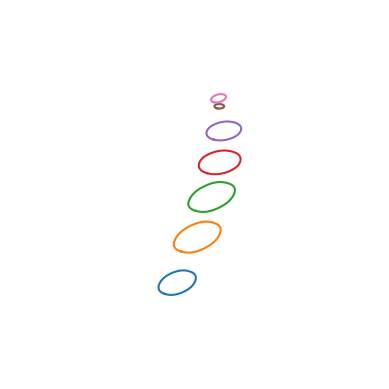

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(r)):
    ax.plot(R[i, :, 0], R[i, :, 1], Z[i]*np.ones(r.shape[1]+1, dtype=np.float32))

plt.axis('equal')
plt.axis('off')
plt.show()

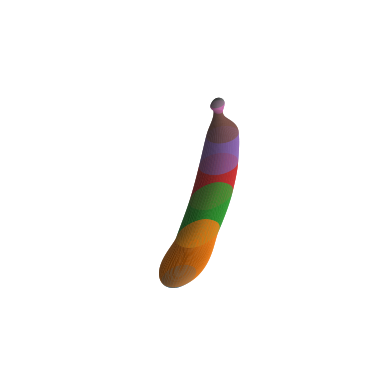

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(FR.shape[0]):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :])

plt.axis('equal')
plt.axis('off')
plt.show()

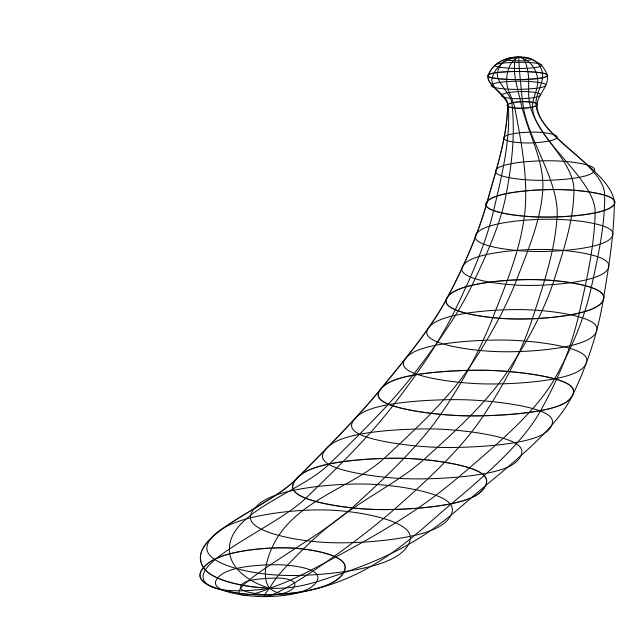

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


for i in range(FR.shape[0]):
    ax.plot_wireframe(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=10, ccount=3, linewidth=0.7, edgecolor='k')
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 3.5)
ax.set_zlim(-1.5, 1.5)
# plt.axis('equal')
ax.view_init(elev=10, azim=10) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("banana.png", dpi=300) #, transparent=True)
plt.show()

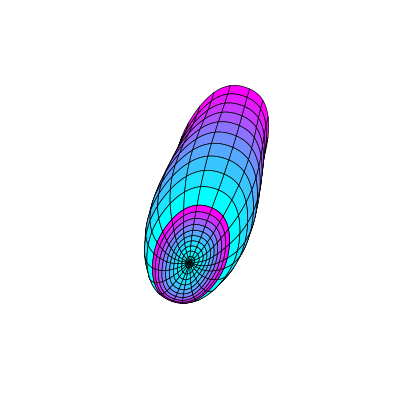

In [21]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(0,2):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')

plt.axis('equal')
ax.view_init(elev=-70, azim=70) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("banana_base.png", dpi=300) #, transparent=True)
plt.show()

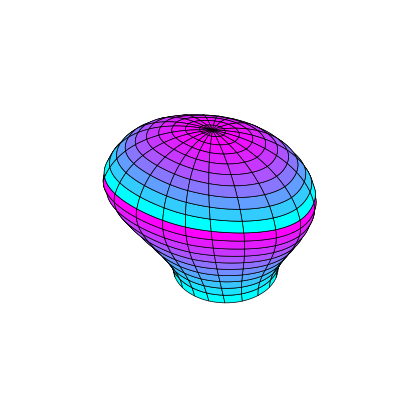

In [22]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(6,8):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')

plt.axis('equal')
ax.view_init(elev=40, azim=20) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("banana_crown.png", dpi=300) # , transparent=True)
plt.show()

# Apple:

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtypes = [torch.float64, torch.float32]

dt = dtypes[0]

N1 = [300, 625, 1250] # The number of points generated horizontally on each countour = 60 * n1
N2 = [1200, 2500, 5000] # The number of points generated in vertical directions

n1 = N1[0]
n2 = N2[0]

d_shapes = ['banana', 'apple', 'vase']
ds = d_shapes[1]

I, Z, Null_Hts = data_3d_shape(ds, dtype=dt, device=device)

tot_pts, seg_pts = t_no_pts(I, n1)

N = len(seg_pts)
M = 4
step = tot_pts // M

r = []
for k in range(len(I)):
    r.append(curve_goodman_torch(I[k], seg_pts[k]))

r = torch.stack(r).to(device)
R = match_parameters_torch_seq(r, N, tot_pts, M)
B_Point, C_Point = base_crown_pt(R, N, tot_pts, M, step)

if ds == 'apple':
  B = Null_Hts[0]
  T = Null_Hts[1]
  bt = ct = 'n'
else:
  B, T = base_crown_ht(R, N, tot_pts, M, step, Z, Null_Hts)
  bt = ct = 'y'

gR, gz, gRB, gRC, fb, fc = surf_tangent(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
FR = torch.zeros((N + 1, tot_pts + 1, n2 + 1, 2), dtype=dt, device=device)
Fz = torch.zeros((N + 1, tot_pts + 1, n2 + 1), dtype=dt, device=device)
surf_pts_inplace_vectorized(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, FR, Fz, bt, ct, n2)

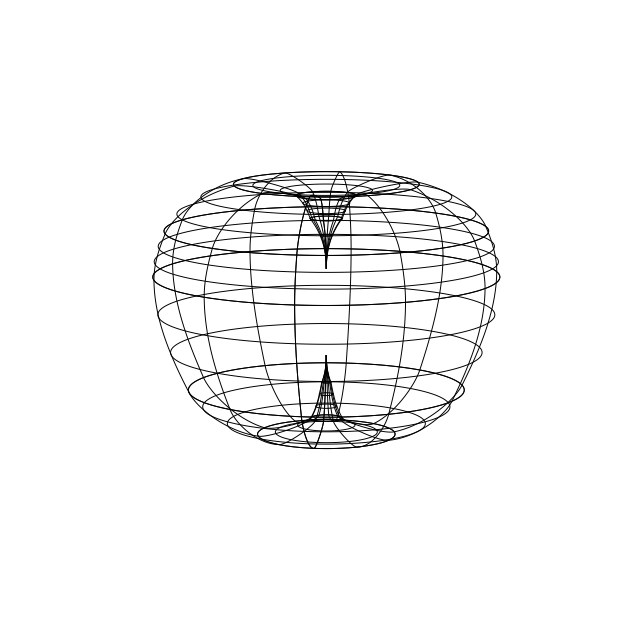

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


for i in range(FR.shape[0]):
    ax.plot_wireframe(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=10, ccount=3, linewidth=0.7, edgecolor='k')

plt.axis('equal')
ax.view_init(elev=10, azim=10) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("apple.png", dpi=300) #, transparent=True)
plt.show()

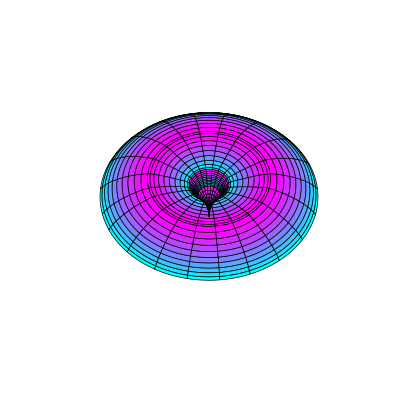

In [24]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(6,10):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')
plt.axis('equal')
ax.view_init(elev=-50, azim=100) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("apple_crown.png", dpi=300) #, transparent=True)
plt.show()

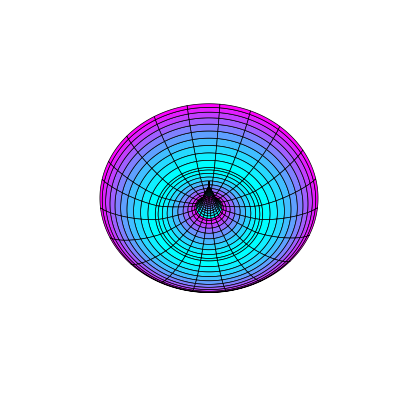

In [26]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(0,4):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')

plt.axis('equal')
ax.view_init(elev=60, azim=100) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("apple_base.png", dpi=300) #, transparent=True)
plt.show()

# Vase:

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtypes = [torch.float64, torch.float32]

dt = dtypes[0]

N1 = [300, 625, 1250] # The number of points generated horizontally on each countour = 60 * n1
N2 = [1200, 2500, 5000] # The number of points generated in vertical directions

n1 = N1[0]
n2 = N2[0]

d_shapes = ['banana', 'apple', 'vase']
ds = d_shapes[2]

I, Z, Null_Hts = data_3d_shape(ds, dtype=dt, device=device)

tot_pts, seg_pts = t_no_pts(I, n1)

N = len(seg_pts)
M = 4
step = tot_pts // M

r = []
for k in range(len(I)):
    r.append(curve_goodman_torch(I[k], seg_pts[k]))

r = torch.stack(r).to(device)
R = match_parameters_torch_seq(r, N, tot_pts, M)
B_Point, C_Point = base_crown_pt(R, N, tot_pts, M, step)

if ds == 'apple':
  B = Null_Hts[0]
  T = Null_Hts[1]
  bt = ct = 'n'
else:
  B, T = base_crown_ht(R, N, tot_pts, M, step, Z, Null_Hts)
  bt = ct = 'y'

gR, gz, gRB, gRC, fb, fc = surf_tangent(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
FR = torch.zeros((N + 1, tot_pts + 1, n2 + 1, 2), dtype=dt, device=device)
Fz = torch.zeros((N + 1, tot_pts + 1, n2 + 1), dtype=dt, device=device)
surf_pts_inplace_vectorized(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, FR, Fz, bt, ct, n2)

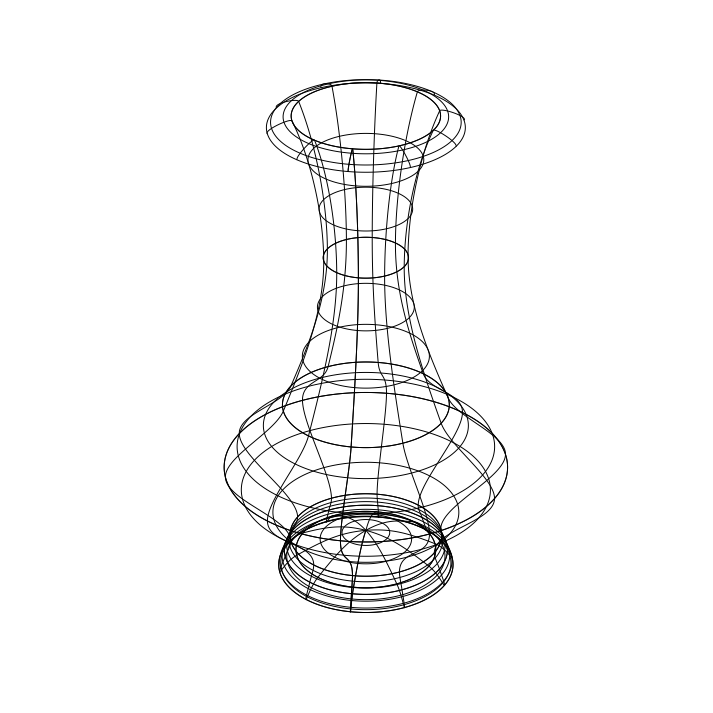

In [29]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')


for i in range(0, FR.shape[0]-1):
    ax.plot_wireframe(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=10, ccount=3, linewidth=0.7, edgecolor='k')

plt.axis('square')
ax.view_init(elev=30, azim=10) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("vase.png", dpi=300) #, transparent=True)
plt.show()

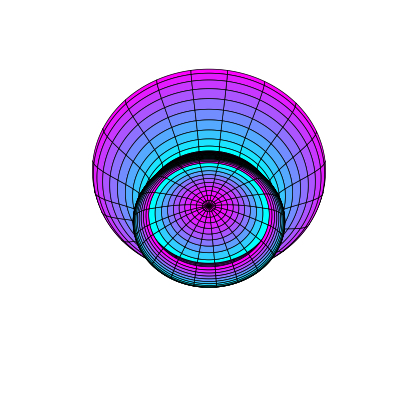

In [28]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(0,5):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')

plt.axis('square')
ax.view_init(elev=-60, azim=100) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("vase_base.png", dpi=300) #, transparent=True)
plt.show()